# Introduction 

We will simulate an instrument with a `field` parameter. We set a new value for the field with a `set_field` method which will ramp the `field` parameter with an exponential decay curve from the old to the new setpoint: 

$current = new - (new-old) * 2^{-t/\lambda}$

The `set_field` method has an optional argument `blocking`. When True, the method will not return until $|new - current| < 0.01$. If blocking is False, the new set point will be set and the method will return immediately. The current field value can then be accessed by calling the get method of the `field` parameter. 

In this notebook, we will illustrate the use of the `time_trace` function in the sweep module. We will set the field to a value `xstart` by calling `set_field` with `blocking=True`. After this we will set the field target to `xend` by calling the same method with `blocking=False`. We will immediately thereafter start a time trace where we monitor the `field` parameter. After we reach the set point the time trace will end and we will plot the resulting curve

## Imports

In [1]:
%matplotlib notebook

import numpy as np
import time 
import matplotlib.pyplot as plt

from pytopo.sweep import sweep, measure, time_trace, do_experiment, getter, setter, call
from pytopo.sweep.base import Zip

from qcodes import Instrument, new_experiment, Parameter
from qcodes.dataset.database import initialise_database
from qcodes.dataset.data_export import get_data_as_pandas_df

import plottr

pyqtgraph plotting not supported, try "from qcodes.plots.pyqtgraph import QtPlot" to see the full error


## Simulated instrument

In [2]:
class ExpDecay: 
    def __init__(self, lamb):
        self._lamb = lamb
        self._current_value = 0
        self._last_read = time.time()
        self._setpoint = 0
    
    def read(self): 
        current_time = time.time()
        dt = current_time - self._last_read
        self._current_value = self._setpoint - (self._setpoint - self._current_value) * 2**(-dt/self._lamb)
        self._last_read = current_time
        return self._current_value

    def set_setpoint(self, new_setpoint): 
        self.read()
        self._setpoint = new_setpoint
        self.read()
        
    def ramping(self): 
        return abs(self.read() - self._setpoint) > 0.01
    
    def set_lambda(self, lamb): 
        self._lamb = lamb
        
    @property
    def lamb(): 
        return self._lamb

class MockAMI(Instrument): 
    def __init__(self, name): 
        super().__init__(name)
        
        self._lamb = 1.0
        self._exp_decay = ExpDecay(1)
        
        self.add_parameter(
            name="field", 
            unit="T", 
            get_cmd=self._exp_decay.read
        )
    
        self.add_parameter(
            "ramping_state", 
            get_cmd=lambda: {True: "ramping", False: "holding"}[self._exp_decay.ramping()]
        )
        
        self.add_parameter(
            name="lamb", 
            set_cmd=self._exp_decay.set_lambda, 
            get_cmd=lambda: self._exp_decay.lamb 
        )
    
    def set_field(self, value, blocking=False): 
        
        self._exp_decay.set_setpoint(value)
        if not blocking: 
            return 
        
        while self.ramping_state() == "ramping": 
            time.sleep(0.1)
        
        return

## Performing the measurement

In [3]:
ami = MockAMI("ami")

In [4]:
xstart = 2
xend = 4

In [31]:
ami.set_field(xstart, blocking=True)

sweep_object = \
time_trace(interval_time=0.1, stop_condition=lambda: ami.ramping_state()=="holding")(
    measure(ami.field)
)

ami.set_field(xend, blocking=False)

data = do_experiment(
    "simple_decay/1",
    sweep_object
)

Starting experimental run with id: 34


<IPython.core.display.Javascript object>


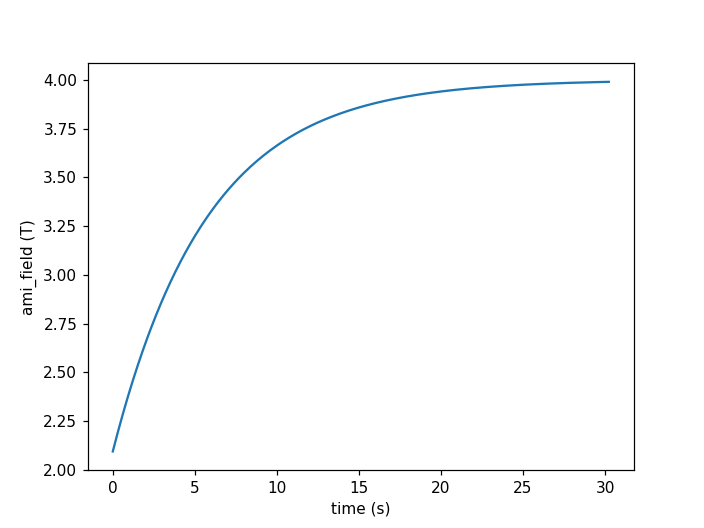

In [32]:
data.plot()

## Sweeping $\lambda$

Now let us repeat this measurement in a loop, where we sweep through values of the decay constant $\lambda$

In [8]:
sweep_object = \
sweep(ami.lamb, [1., 2., 3., 4.])(
    call(ami.set_field, xstart, blocking=True), 
    call(ami.set_field, xend, blocking=False),
    time_trace(interval_time=0.1, stop_condition=lambda: ami.ramping_state()=="holding")(
        measure(ami.field)
    )
)

data = do_experiment(
    "repeated_decay/1",
    sweep_object
)

Starting experimental run with id: 33


We will plot 4 1D curves in one axis. To plot this, we need to convert the data set to a pandas data frame. 

In [9]:
df = get_data_as_pandas_df(data.run_id)[0]

<IPython.core.display.Javascript object>


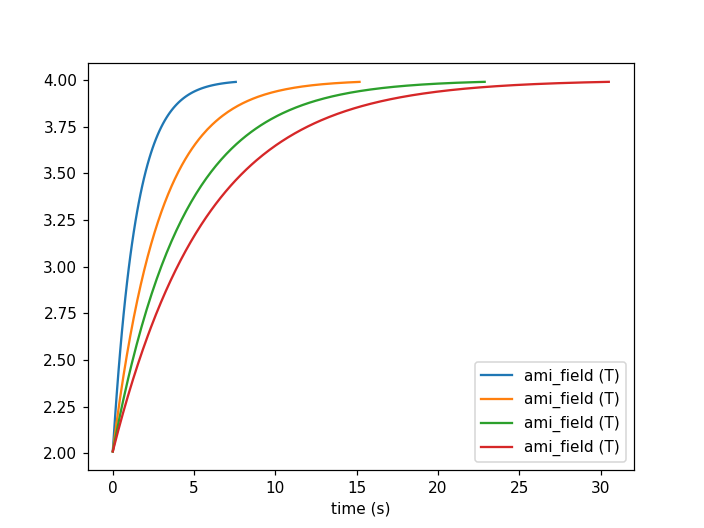

ami_lamb ()
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

In [19]:
fig, ax = plt.subplots()

df.groupby("ami_lamb ()").plot(x="time (s)", y="ami_field (T)", ax=ax)